In [1]:
import sys
sys.path.append('..')

import tomodpdt

import numpy as np
import time
import matplotlib.pyplot as plt

import deeplay as dl

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

c:\Users\fredr\AppData\Local\GitHubDesktop\app-3.4.12\TomoDpDt\Notebooks\..\deeptrack_t\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [2]:
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEV)

Using device: cuda


In [3]:
plotly_3d = True # Do interactive 3D plots with plotly
save_folder = None # Save the results to a folder

if save_folder is not None:
    import os
    os.makedirs(save_folder, exist_ok=True)

## 1 - Import 3D volume data

In this example we load in a 3D volume consisting of small gaussian blobs placed randomly inside a volume. The volume is originally 64x64x64 voxels in size, but can be up/downsampled to any size.



In [4]:
volume = tomodpdt.VOL_GAUSS_MULT

In [5]:
print(f"Shape of the volume: {volume.shape}")

Shape of the volume: (64, 64, 64)


In [6]:
from medmnist import OrganMNIST3D
from torchvision import transforms
import torch

# Define a transform that properly converts the 4D numpy array to a tensor
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))  # Convert to Tensor
])

# Load dataset with the new transform
train_dataset = OrganMNIST3D(root='../test_data', split='train', download=True, transform=transform)

# Get a sample
volume, label = train_dataset[5]

volume = volume[0]

print(f"Sample shape: {volume.shape}")  # Should be (1, 28, 28, 28)
print(f"Label: {label}")


Using downloaded and verified file: ../test_data\organmnist3d.npz
Sample shape: torch.Size([28, 28, 28])
Label: [2]


the 3D volume is stored in a numpy array and can be interactively visualized using the ipyvolume library...

In [7]:
# Visualize the volume in 3D space - needs plotly and ipywidgets
if plotly_3d:
    tomodpdt.plotting.visualize_3d_volume(volume)

or with sum projections along the x, y, and z axes...

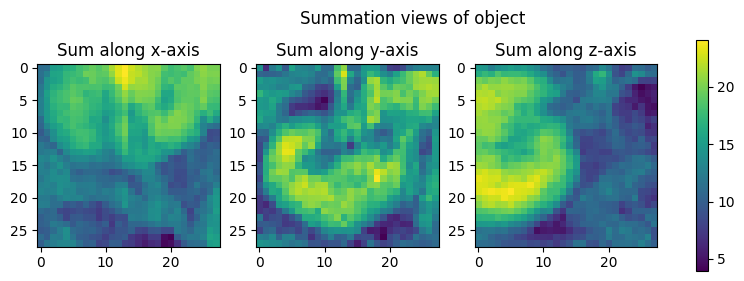

In [8]:
tomodpdt.plotting.plot_sum_object(volume)

## 2 - Choosing the imaging modality

Next step is to choose the image modality, that is, the function which transforms the 3D volume into a 2D image.
In this notebook, we have the most basic imaging modalities, which are sum projections along the x, y, or z axes.

There are two main types of imaging modalities one can use here:

- `Sum3d2d`: Sum of pixel values along an axis
- `SumAvgWeighted3d2d`: Sum of pixel values along an axis weighted by the distance from the top of the volume

In [9]:
from tomodpdt.imaging_modality_torch import SumAvgWeighted3d2d, Sum3d2d

# Define the model and which axis to sum over
sum_model = Sum3d2d(dim=-1)

below we create the data that will be used to train the model. In this case, we are using the `Sum3d2d` imaging modality and the 3d volume data to create the training data...

In [10]:
test_object, q_gt, projections, imaging_model = tomodpdt.simulate.create_data(
    volume=volume, # The volume we want to reconstruct
    image_modality=sum_model, # We use the sum model
    rotation_case='random_sinusoidal', # We rotate the object around 1 main axis, but the other 2 axes are also non-zero an
    samples=400, # Number of projections
    duration=2 # Duration is the number of full revolutions
    )

c:\Users\fredr\AppData\Local\GitHubDesktop\app-3.4.12\TomoDpDt\Notebooks\..\tomodpdt\simulate.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Simulating... 25.0%
Simulating... 50.0%
Simulating... 75.0%


and for sanity check we can see that we have the following shapes...

In [11]:
print(f"Shape of the test_object: {test_object.shape}")
print(f"Shape of the q_gt: {q_gt.shape}")
print(f"Shape of the projections: {projections.shape}")

Shape of the test_object: torch.Size([28, 28, 28])
Shape of the q_gt: torch.Size([400, 4])
Shape of the projections: torch.Size([400, 1, 28, 28])


and the frames look like...

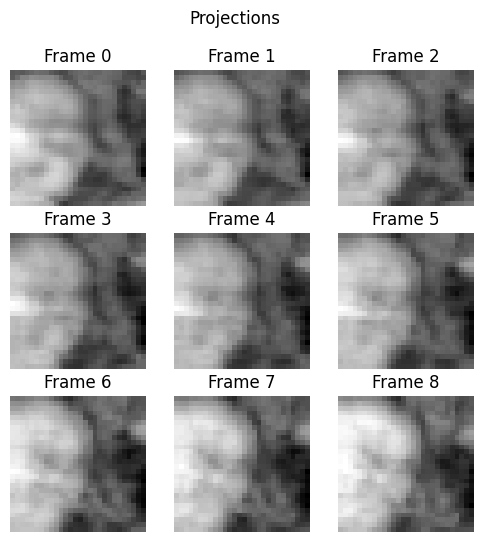

In [12]:
tomodpdt.plotting.plot_grid33_frames(projections, title="Projections")

and the quaternions...

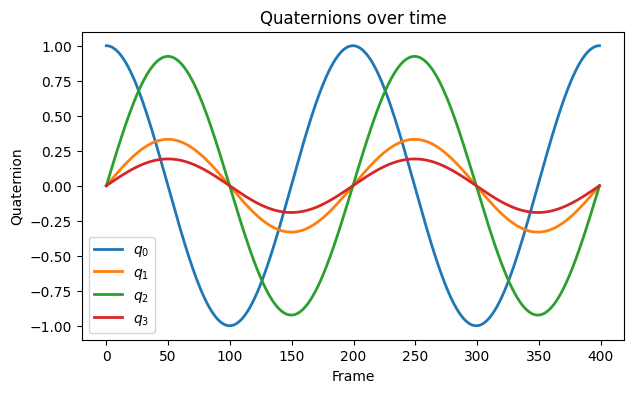

In [13]:
tomodpdt.plotting.plot_quaternions(q_gt)

## 3 - Tomographic Reconstruction

In this step, we focus on tomographic reconstruction—reconstructing a 3D volume from 2D images. This notebook implements a fundamental tomographic reconstruction technique: **backprojection with stochastic gradient descent (SGD).**

Unlike traditional methods, our approach does not rely on prior knowledge of the 3D volume or the rotation parameters, making the problem more challenging. The reconstruction process consists of two key steps:

#### **Step 1: Estimating Initial Rotation Parameters**
- A **variational autoencoder (VAE)** is trained on the 2D images to learn a latent representation and reconstruct them.
- Using this latent representation, we estimate the rotation parameters that best describe the image orientations.

#### **Step 2: Optimizing the 3D Volume and Rotation Parameters**
- **Stochastic gradient descent (SGD)** is used to iteratively refine both the 3D volume and the rotation parameters.
- The optimization is guided by a loss function that considers:
  - **Mean absolute error** between the original 2D images and their forward projections from the 3D volume.
  - **Smoothness constraints** on the reconstructed 3D volume.
  - **Regularization of rotation parameters** to ensure realistic transformations.
  - **Latent space similarity**, enforcing consistency between the VAE’s learned representations of the 2D images and the reconstructed projections.
  - **Total variation** term to promote sparsity in the 3D volume.
  - and some other terms...




### 3.1 - Set up the tomographic reconstruction class

The `Tomography` class is the main class that handles the tomographic reconstruction process. It is built as a `dl.Application` module which allows for easy training and inference. 

In [14]:
# Set the size of the volume, we assume it is a cube.
N=volume.shape[0]

# Create the tomographic_model
tomographic_model = tomodpdt.Tomography(
    volume_size=(N, N, N), # The size of the volume
    initial_volume='refraction', # 'refraction' since we are optimizing the refractive index
    rotation_optim_case='basis', # 'basis' or 'quaternion', 'basis' is smoother
    imaging_model=sum_model, # The imaging model
    )

### 3.2 - Initialize the rotation parameters

As described above, the rotation parameters are initialized using the VAE. The `initialize_parameters` method estimates the initial rotation parameters by fitting the VAE to the 2D images and finds where a full rotation is in the latent space.

In [15]:
# Initialize the parameters
tomographic_model.initialize_parameters(projections, normalize=True)

c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K
1 | fc_mu               | Linear                 | 6.3 K 
2 | fc_var              | Linear                 | 6.3 K 
3 | fc_dec              | Linear                 | 9.4 K 
4 | decoder             | ConvolutionalDecoder2d | 76.3 K
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
153 K     Trai

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 20.25it/s, v_num=4, train_rec_loss_step=1.63e+4, train_KL_step=28.30, train_total_loss_step=1.64e+4]

c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)



Epoch 499: 100%|██████████| 13/13 [00:00<00:00, 78.34it/s, v_num=4, train_rec_loss_step=7.69e+3, train_KL_step=51.90, train_total_loss_step=7.74e+3, train_rec_loss_epoch=1.5e+4, train_KL_epoch=103.0, train_total_loss_epoch=1.51e+4] 


and visualize the initial rotation parameters...

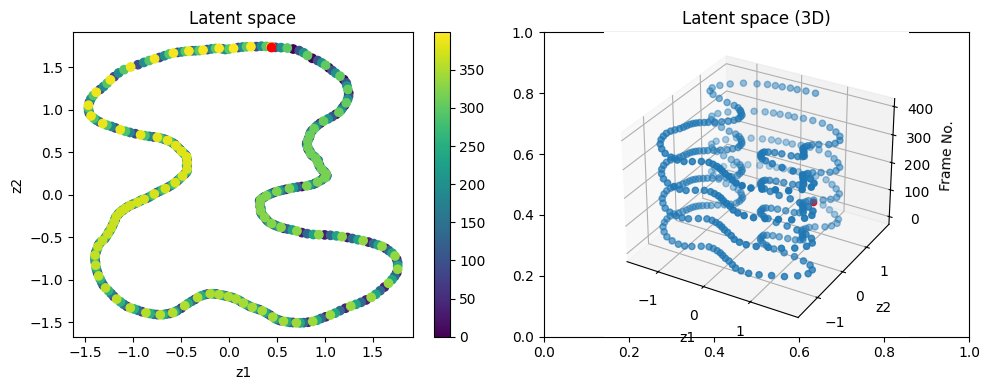

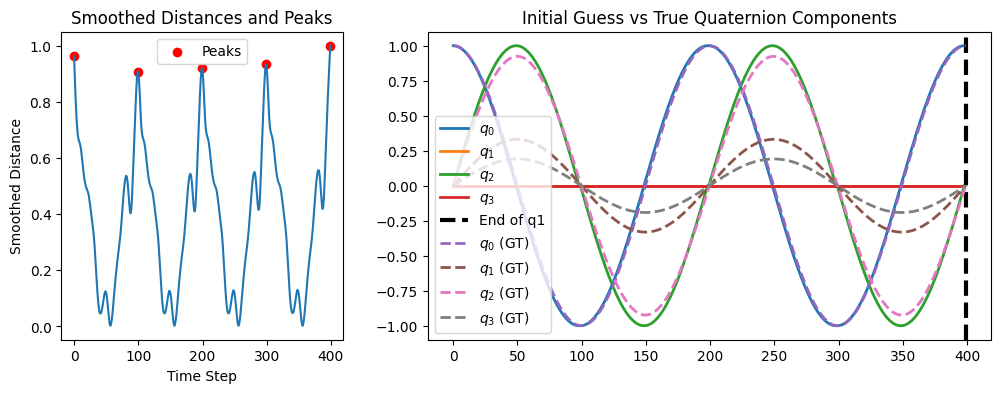

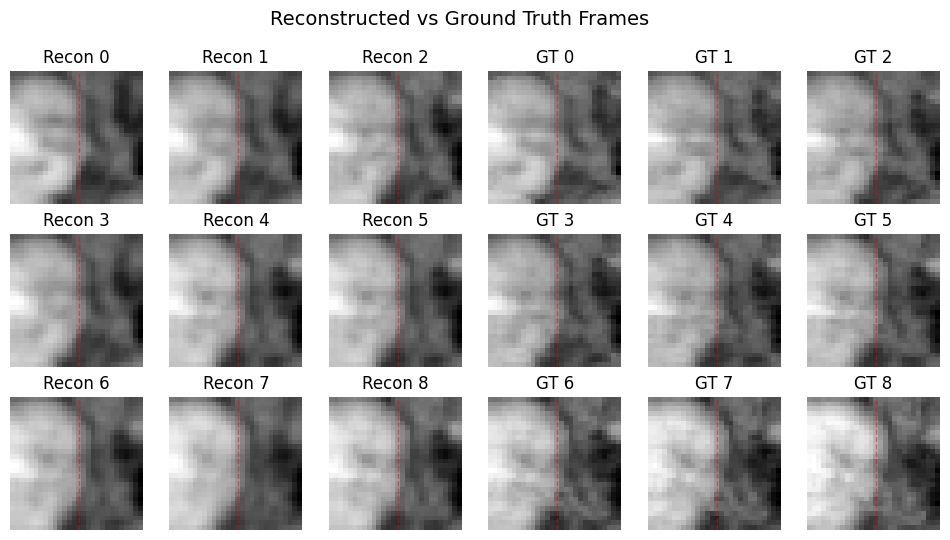

In [16]:
tomodpdt.plotting.plots_initial(tomographic_model, gt=q_gt.to('cpu'), save_folder=save_folder)

### 3.3 - Optimize the volume alone first

The optmization flows better when an initial volume is optimized first. This is done by optimizing the volume alone for a few iterations before optimizing the volume and rotation parameters together. Here  one can also provide the initial volume to start the optimization from, but in this case we are starting from a fixed volume of 1.33.

In [17]:
N = len(tomographic_model.frames) # Number of frames
idx = torch.arange(N) # Index of frames
epochs_object_only = 100 # Number of epochs for the object only optimization
batch_size_object_only = 64 # Batch size for the object only optimization

train the model for `epochs_object_only` epochs...

In [18]:
# Toggle the gradients of the quaternion parameters to False
tomographic_model.toggle_gradients_quaternion(False)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_only, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_only , shuffle=True))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


  | Name          | Type                   | Params
---------------------------------------------------------
0 | vae_model     | VariationalAutoEncoder | 153 K 
1 | encoder       | ConvolutionalEncoder2d | 55.7 K
2 | fc_mu         | Linear                 | 6.3 K 
3 | imaging_model | Sum3d2d                | 0     
4 | train_metrics | MetricCollection       | 0     
5 | val_metrics   | MetricCollection       | 0     
6 | test_metrics  | MetricCollection       | 0     
7 | optimizer     | Adam                   | 0     
---------------------------------------------------------
22.0 K    Trainable params
154 K     Non-trainable params
175 K     Total params
0.704     Total estimated model params size (MB)
c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\lightnin

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 35.35it/s, v_num=5, train_proj_loss_step=2.200, train_latent_loss_step=0.468, train_rtv_loss_step=0.00558, train_qv_loss_step=0.000553, train_q0_loss_step=0.000, train_rtr_loss_step=0.000, train_so_loss_step=0.662, train_total_loss_step=3.330, train_proj_loss_epoch=2.200, train_latent_loss_epoch=0.498, train_rtv_loss_epoch=0.00545, train_qv_loss_epoch=0.000406, train_q0_loss_epoch=0.00846, train_rtr_loss_epoch=0.000, train_so_loss_epoch=0.660, train_total_loss_epoch=3.370]     
Training time:  0.3275875647862752  minutes
No history to plot...


### 3.4 - Optimize the 3D volume and the rotation parameters

Here is the main optimization loop where the 3D volume and the rotation parameters are optimized together.

In [19]:
epochs_object_rot = 1250
batch_size_object_rot = 128

and train the model for `epochs_object_rot` epochs...

In [20]:
# Toggle the gradients of the quaternion parameters
tomographic_model.toggle_gradients_quaternion(True)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_rot, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_rot, shuffle=False))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")


  | Name          | Type                   | Params
---------------------------------------------------------
0 | vae_model     | VariationalAutoEncoder | 153 K 
1 | encoder       | ConvolutionalEncoder2d | 55.7 K
2 | fc_mu         | Linear                 | 6.3 K 
3 | imaging_model | Sum3d2d                | 0     
4 | train_metrics | MetricCollection       | 0     
5 | val_metrics   | MetricCollection       | 0     
6 | test_metrics  | MetricCollection       | 0     
7 | optimizer     | Adam                   | 0     
---------------------------------------------------------
22.0 K    Trainable params
153 K     Non-trainable params
175 K     Total params
0.704     Total estimated model params size (MB)
c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: PossibleUserWarning:

The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see lo

Epoch 1249: 100%|██████████| 4/4 [00:00<00:00, 18.23it/s, v_num=6, train_proj_loss_step=0.0939, train_latent_loss_step=0.0188, train_rtv_loss_step=0.0812, train_qv_loss_step=0.000425, train_q0_loss_step=0.000, train_rtr_loss_step=0.000, train_so_loss_step=0.801, train_total_loss_step=0.995, train_proj_loss_epoch=0.153, train_latent_loss_epoch=0.0195, train_rtv_loss_epoch=0.0812, train_qv_loss_epoch=0.00134, train_q0_loss_epoch=0.000317, train_rtr_loss_epoch=0.000, train_so_loss_epoch=0.801, train_total_loss_epoch=1.060]  
Training time:  4.932803591092427  minutes
No history to plot...


## 4.0 - Visualize the reconstructed volume and the parameters

Finally, we visualize the reconstructed volume and the rotation parameters. The reconstructed volume is visualized as a 3D volume, and the rotation parameters are visualized as a 3D scatter plot.

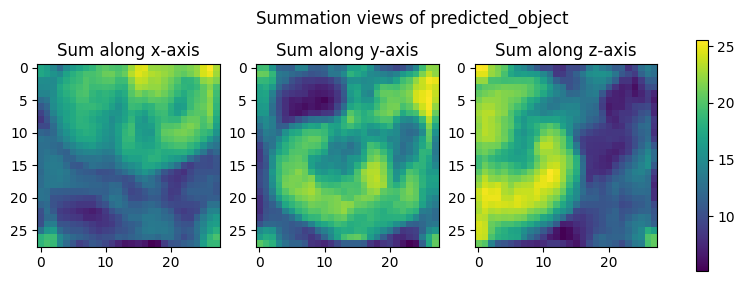

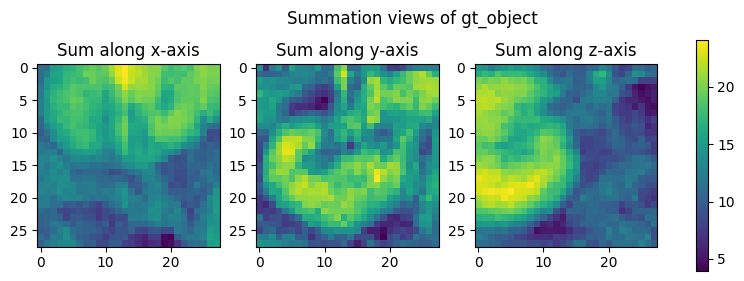

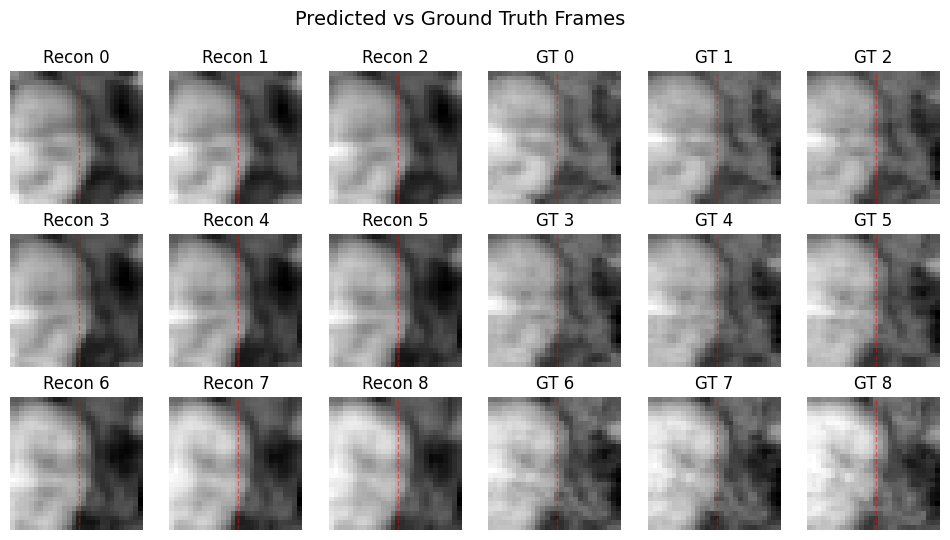

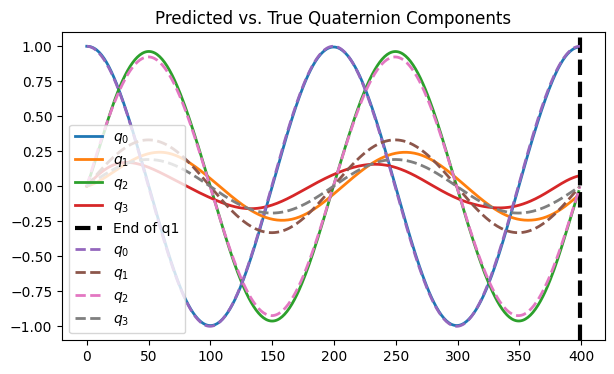

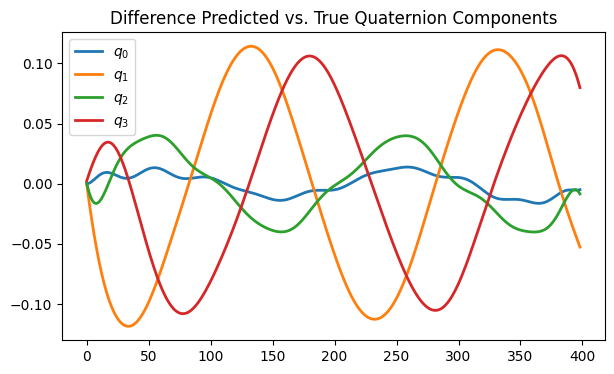

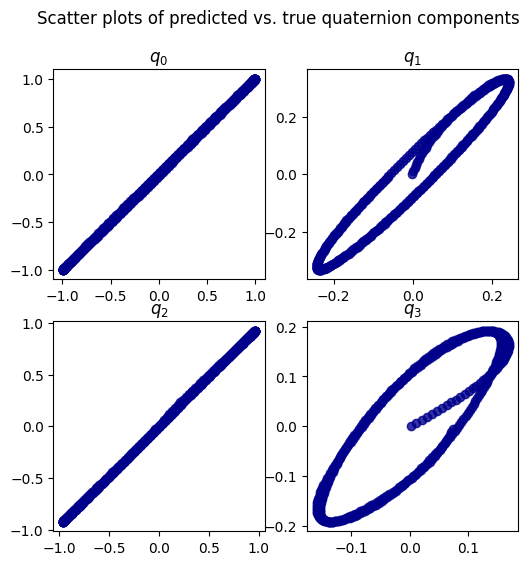

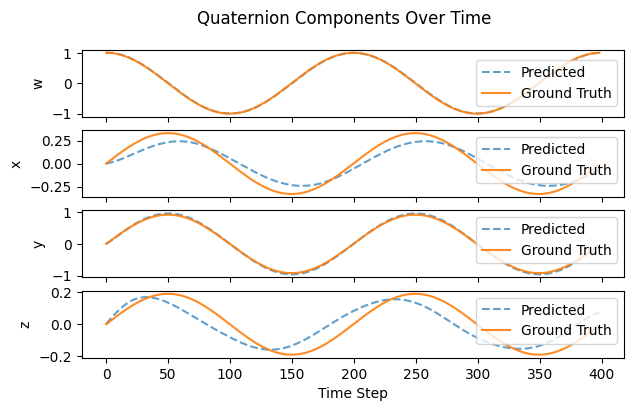

In [21]:
# Move it to the GPU if possible for faster plotting
tomographic_model.move_all_to_device(DEV)

# Visualize the final volume and rotations.
tomodpdt.plotting.plots_optim(tomographic_model, gt_q=q_gt.to('cpu'), gt_v=test_object.to('cpu'), plot_3d=plotly_3d, save_folder=save_folder)

## 5 - Save the reconstructed volume and the parameters

In [22]:
if save_folder is not None:
    
    # save the volume as a numpy array
    np.save(f'{save_folder}/volume.npy', tomographic_model.volume.cpu().detach().numpy())

    # save the quaternions as a numpy array
    quaternions_pred = tomographic_model.get_quaternions_final().detach().cpu().numpy()
    np.save(f'{save_folder}/quaternions.npy', quaternions_pred)
